In [5]:
import scanpy
from matplotlib_venn import venn2
import pandas as pd
import gseapy as gp
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
scanpy.set_figure_params(dpi_save=200)

In [13]:
patient_degs = {}

In [14]:
patient1_degs = pd.read_excel('data/human_stressors.xlsx', sheet_name='Supplementary Data 2', header=1,skiprows=1)
patient_degs['1'] = patient1_degs.iloc[:, 63:132]

In [15]:
patient2_degs = pd.read_excel('data/human_stressors.xlsx', sheet_name='Supplementary Data 3', header=1,skiprows=1)
patient_degs['2'] = patient2_degs.iloc[:, 63:132]

In [16]:
patient3_degs = pd.read_excel('data/human_stressors.xlsx', sheet_name='Supplementary Data 4', header=1,skiprows=1)
patient_degs['3'] = patient3_degs.iloc[:, 63:132]

In [17]:
patient4_degs = pd.read_excel('data/human_stressors.xlsx', sheet_name='Supplementary Data 5', header=1,skiprows=1)
patient_degs['4'] = patient4_degs.iloc[:, 66:128]

In [18]:
patient5_degs = pd.read_excel('data/human_stressors.xlsx', sheet_name='Supplementary Data 6', header=1,skiprows=1)
patient_degs['5'] = patient5_degs.iloc[:, 67:129]

In [19]:
patient_degs_beta_condition_specific = defaultdict(list)
for patient in ['1', '2', '3', '4', '5']:
    for i in range(7):
        if patient in ['4', '5']:
            df = patient_degs[patient].iloc[:, (i*9):(i*9)+8].dropna(axis=0, how='all')
            df.columns = [x.split('.')[0] for x in df.columns]
            df.columns = ['gene'] + df.columns.tolist()[1:]
        else:
            df = patient_degs[patient].iloc[:, (i*10)+1:(i*10)+9].dropna(axis=0, how='all')
            df.columns = [x.split('.')[0] for x in df.columns]
        
        df.set_index('gene', inplace=True)    
        condition = df['stressor'].iloc[0]
        patient_degs_beta_condition_specific[condition].append(df)

In [20]:
stressors = patient_degs_beta_condition_specific.keys()

In [14]:
for stressor in list(stressors):
    all_upreg = []
    for pt in patient_degs_beta_condition_specific[stressor]:
        upreg = pt.query('avg_log2FC >= 0.25').index.tolist()
        all_upreg.extend(upreg)
    all_upreg = pd.Series(all_upreg).value_counts()[pd.Series(all_upreg).value_counts() >= 3].index.tolist() # majority
    enr = gp.enrichr(gene_list=all_upreg, # or "./tests/data/gene_list.txt",
                         gene_sets=['BioPlanet_2019', 'Panther_2016', 'KEGG_2019_Human', 'Reactome_2022', 'GO_Biological_Process_2023'],
                         organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                         outdir=None, # don't write to disk,
                         cutoff = 1
                        )
    res = enr.results[enr.results['Adjusted P-value'] < 0.05]
    res['Overlap'] = res['Overlap'].str.replace('/', ' of ')
    res.to_csv(f'results/GSEA_{stressor}_vs_CTRL.csv')

/tmp/ipykernel_3604825/1318725488.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Overlap'] = res['Overlap'].str.replace('/', ' of ')
/tmp/ipykernel_3604825/1318725488.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Overlap'] = res['Overlap'].str.replace('/', ' of ')
/tmp/ipykernel_3604825/1318725488.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

## Get gene sets from increasing trends

In [3]:
gene_cluster_increasing = pd.read_csv('../analysis_beta_trajectories/results/gene_cluster_increasing.csv', index_col=0)

In [7]:
gene_cluster_increasing['Gene_set_Term'] = gene_cluster_increasing['Gene_set'] + '_' + gene_cluster_increasing['Term']

In [8]:
all_conditons_enriched_sets = pd.concat((pd.DataFrame(['increasing_in_obesity']*len(gene_cluster_increasing['Gene_set_Term']), columns=['stressor']),
           gene_cluster_increasing['Gene_set_Term'].reset_index(drop=True), gene_cluster_increasing['Genes'].reset_index(drop=True)), axis=1)

In [21]:
for stressor in list(stressors):
    df = pd.read_csv(f'results/GSEA_{stressor}_vs_CTRL.csv')
    df['Gene_set_Term'] = df['Gene_set'] + '_' + df['Term']
    df = pd.concat((pd.DataFrame([stressor]*len(df['Gene_set_Term']), columns=['stressor']), df['Gene_set_Term'], df['Genes']), axis=1)
    all_conditons_enriched_sets = pd.concat((all_conditons_enriched_sets, df))

In [22]:
all_conditons_enriched_sets

,stressor,Gene_set_Term,Genes
0,increasing_in_obesity,BioPlanet_2019_Translation,RPL4;RPL5;RPL30;TRAM1;RPL3;RPL31;RPL34;RPL10A;...
1,increasing_in_obesity,BioPlanet_2019_Cytoplasmic ribosomal proteins,RPL4;RPL5;RPL30;RPL3;RPL31;RPL34;RPL10A;RPL8;R...
2,increasing_in_obesity,BioPlanet_2019_Influenza viral RNA transcripti...,RPL4;RPL5;RPL30;RPL3;RPL31;RPL34;RPL10A;RPL8;R...
3,increasing_in_obesity,BioPlanet_2019_Influenza infection,RPL4;RPL5;RPL30;RPL3;RPL31;RPL34;CLTA;RPL10A;R...
4,increasing_in_obesity,BioPlanet_2019_Protein metabolism,RPL4;RPL5;RPL30;RPL3;RPL31;RPL34;PROS1;RPL8;RP...
...,...,...,...
645,TNFA,GO_Biological_Process_2023_Positive Regulation...,CLIP3;EGR1;CD74;CD40;CDKN1A;HSP90AA1;NNMT;CAMT...
646,TNFA,GO_Biological_Process_2023_Negative Regulation...,IFIH1;PLSCR1;OAS1;TNIP1;N4BP1
647,TNFA,GO_Biological_Process_2023_Positive Regulation...,PPP1R15A;ITGA1;CAMTA1;CALM2
648,TNFA,GO_Biological_Process_2023_Negative Regulation...,DNAJA1;TNFAIP3;SQSTM1;SOX4;N4BP1


In [23]:
all_conditons_enriched_sets.to_csv('results/all_upregulated_gene_sets_in_stress.csv')

In [24]:
increasing_in_obesity = set(all_conditons_enriched_sets[all_conditons_enriched_sets['stressor'] == 'increasing_in_obesity']['Gene_set_Term'])

In [25]:
ob_color = sns.color_palette('tab10')[1]
er_color = sns.color_palette('BuPu')[2]
cm_color = sns.color_palette('BuPu')[-1]

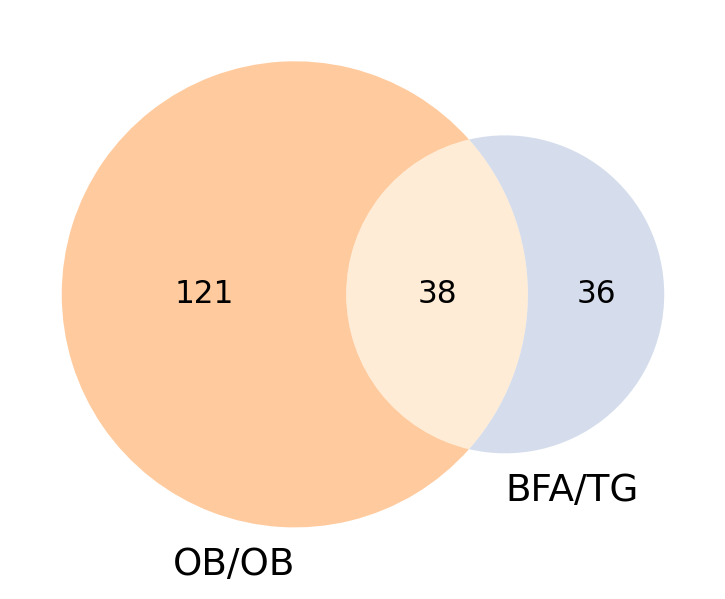

<Figure size 320x320 with 0 Axes>

In [26]:
bfa_terms = all_conditons_enriched_sets[all_conditons_enriched_sets['stressor'] == 'BFA']['Gene_set_Term']
tg_terms = all_conditons_enriched_sets[all_conditons_enriched_sets['stressor'] == 'TG']['Gene_set_Term']
er_intersection = set(bfa_terms).intersection(tg_terms)

fig, ax = plt.subplots(figsize=(5,4))
venn2([increasing_in_obesity, er_intersection],
      set_labels=['OB/OB', 'BFA/TG'], 
      set_colors=[ob_color, er_color], ax=ax)
plt.tight_layout()
fig.savefig('figures/obesity_er_stress_gene_set_venn.png', dpi=200)
plt.show(); plt.clf()

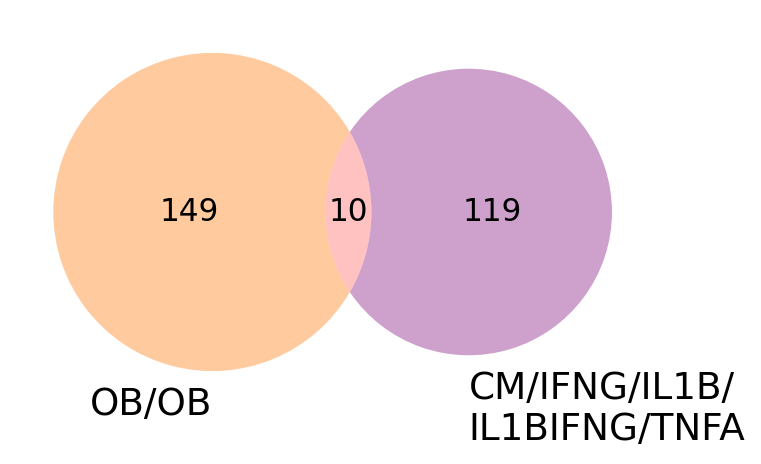

<Figure size 320x320 with 0 Axes>

In [27]:
bfa_terms = set(all_conditons_enriched_sets[all_conditons_enriched_sets['stressor'] == 'CM']['Gene_set_Term'])
ifng_terms = set(all_conditons_enriched_sets[all_conditons_enriched_sets['stressor'] == 'IFNG']['Gene_set_Term'])
il1b_terms = set(all_conditons_enriched_sets[all_conditons_enriched_sets['stressor'] == 'IL1B']['Gene_set_Term'])
il1bifng_terms = set(all_conditons_enriched_sets[all_conditons_enriched_sets['stressor'] == 'IL1BIFNG']['Gene_set_Term'])
tnfa_terms = set(all_conditons_enriched_sets[all_conditons_enriched_sets['stressor'] == 'TNFA']['Gene_set_Term'])
cytokine_intersection = set.intersection(bfa_terms, ifng_terms, il1b_terms, il1bifng_terms, tnfa_terms)

fig, ax = plt.subplots(figsize=(5,4))
venn2([increasing_in_obesity, cytokine_intersection],
      set_labels=['OB/OB', 'CM/IFNG/IL1B/\nIL1BIFNG/TNFA'],
      set_colors=[ob_color, cm_color], ax=ax)

plt.tight_layout()
fig.savefig('figures/obesity_cytokine_stress_gene_set_venn.png', dpi=200)
plt.show(); plt.clf()

In [7]:
total_gene_set_count = 0
for gene_set in ['BioPlanet_2019', 'Panther_2016', 'KEGG_2019_Human', 'Reactome_2022', 'GO_Biological_Process_2023']:
    total_gene_set_count += len(gp.get_library(gene_set))

In [17]:
M = total_gene_set_count # total number of gene sets tested
n = 121 + 38
N = 38 + 36
x = 38

stats.hypergeom(M, n, N).sf(x-1)

1.2120744575481524e-48

In [18]:
M = total_gene_set_count # total number of gene sets tested
n = 149 + 10
N = 10 + 119
x = 10

stats.hypergeom(M, n, N).sf(x-1)

7.880879659812024e-05